In [2]:
% matplotlib inline

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('white')

In [3]:
from glob import glob 
import os
from tqdm import tqdm_notebook as tqdm 


import numpy as np
import scipy.ndimage
import cv2
from multiprocessing import Pool

import sys
sys.path.append('../scripts')
sys.path.append('../nets')
import load_utils
import watereshed
import generator_3D
import unet

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
PATHS = {
    'DATA': '/home/ubuntu/cdata/DM_Data/RIII',
    'DESC': '/home/ubuntu/cdata/DM_Data/REPRISEIIISizes.xlsx'
}

In [5]:
model = unet.get_unet(224, 224)

In [6]:
def load(patient_id):
    patch = np.load(os.path.join(PATHS['DATA'], patient_id, 'patch.npy'))
    return patch[np.random.randint(len(patch))]

In [524]:
def preprocess_test(patch):
    window = min(min(patch.shape), int(1.7 * SIDE))
    point = np.array(patch.shape) // 2 - window // 2
    point = np.clip(point, 0, np.array(patch.shape) - window)
    patch = patch[
        point[0]: point[0] + window, 
        point[1]: point[1] + window
    ]

    clip = np.zeros((SIDE, SIDE, 2))
    clip = cv2.resize(patch, dsize=(SIDE, SIDE))
    return clip

In [513]:
def preprocess_val(patch):
    window = min(min(patch.shape[:-1]), SIDE)
    point = np.array(patch.shape[:-1]) // 2
    point = np.clip(point, 0, np.array(patch.shape[:-1]) - window)
    
    patch = patch[
        point[0]: point[0] + window, 
        point[1]: point[1] + window
    ]

    clip = np.zeros((SIDE, SIDE, 2))
    clip[..., 0] = cv2.resize(patch[..., 0], dsize=(SIDE, SIDE))
    clip[..., -1] = cv2.resize(patch[..., -1], dsize=(SIDE, SIDE)) 
    return clip

In [514]:
def preprocess_train(patch):
    if np.random.randint(2):
        patch = np.flip(patch, 0)
    
    if np.random.randint(2):
        patch = np.flip(patch, 1)
    
    if np.random.randint(3):
        shift = np.random.uniform(-.2, .2, size=2)
        shift *= np.array(patch.shape[:2])
        patch = np.dstack([
            scipy.ndimage.shift(patch[..., 0], shift),
            scipy.ndimage.shift(patch[..., -1], shift, order=0)
        ])
        
    if np.random.randint(3):
        rotate = np.random.uniform(-40, 40)
        patch = np.dstack([
            scipy.ndimage.rotate(patch[..., :-1], rotate),
            scipy.ndimage.rotate(patch[..., -1:], rotate, order=0)
        ])
    
#     if np.random.randint(3):
#         zoom = np.random.uniform(.8, 1.5)
#         patch = np.dstack([
#             scipy.ndimage.zoom(patch[..., :-1], zoom),
#             scipy.ndimage.zoom(patch[..., -1:], zoom, order=0)
#         ])
    
    
    scale = np.random.uniform(.5, 1.5)
    window = min(min(patch.shape[:-1]), int(SIDE * scale))
    if np.count_nonzero(patch[..., 1]):
        coords = np.array(np.where(patch[..., 1]))
        cmin, cmax = coords.min(1) - window, coords.max(1)
        point = np.array([
            np.random.randint(cmin[0], cmax[0]),
            np.random.randint(cmin[1], cmax[1])
        ])
    else:
        point = np.random.randint(0, min(patch.shape[:-1]) - window + 1)
    point = np.clip(point, 0, np.array(patch.shape[:-1]) - window)
    
    patch = patch[
        point[0]: point[0] + window, 
        point[1]: point[1] + window
    ]


    clip = np.zeros((SIDE, SIDE, 2))
    clip[..., 0] = cv2.resize(patch[..., 0], dsize=(SIDE, SIDE))
    clip[..., -1] = cv2.resize(patch[..., -1], dsize=(SIDE, SIDE)) 
    return clip

In [472]:
SIDE = 224
BATCH_SIZE = 32
SPLIT = .15

In [463]:
import pickle


processed_meta = pickle.load(open('../../DM_Data/RIII/processed_meta.pkl', 'rb'))
picks = [pm['picks'] for pm in processed_meta]

In [515]:
def test_generator(patient, train_mode=False, batch_size=BATCH_SIZE):
    for i in range(len(patient) // batch_size + 1):
        batch = patient[i * batch_size: (i + 1) * batch_size]
        processed = list(map(preprocess_test, batch))
        processed = np.array(processed)
        yield (np.expand_dims(processed, -1) + 199.) / 461.

In [516]:
def generator(patient_ids, train_mode=False, batch_size=BATCH_SIZE):
    while True:
        if train_mode:
            np.random.shuffle(patient_ids)
            
        for i in range(len(patient_ids) // batch_size + 1):
            batch = patient_ids[i * batch_size: (i + 1) * batch_size]
#             with Pool(4) as pool:
#             processed = list(map(load, batch))

#         #     for p in p:
#             if train_mode:
#                 with Pool(4) as pool:
#                     processed = pool.map(preprocess_train, processed)
#             else:
#                 with Pool(4) as pool:
#                     processed = pool.map(preprocess_val, processed)
            with Pool(4) as pool:
                processed = pool.map(load, batch)

        #     for p in p:
            if train_mode:
                processed = list(map(preprocess_train, processed))
            else:
                processed = list(map(preprocess_val, processed))
            processed = np.array(processed)
            yield (np.expand_dims(processed[..., 0], -1) + 199.) / 461., np.expand_dims(processed[..., 1], -1) > 0

In [12]:
patient_ids = glob(os.path.join(PATHS['DATA'], '*', 'patch.npy'))
patient_ids = [os.path.dirname(pid) for pid in patient_ids]
patient_ids = [os.path.basename(pid) for pid in patient_ids if len(os.path.basename(pid)) == 9]

In [13]:
from keras.callbacks import ModelCheckpoint

In [643]:
patient, meta = load_utils.load_patient(PATHS['DATA'], test[16], metadata=True)
patient.shape

(466, 512, 512)

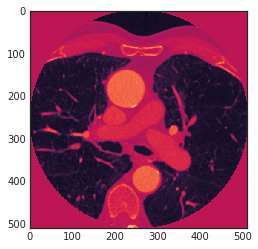

In [644]:
plt.imshow(patient[0])

In [629]:
patient = np.flip(patient, 0)

In [645]:
test_gen = test_generator(patient)
arr = np.concatenate([next(test_gen) for i in range(len(patient) // BATCH_SIZE + 1)])
test_gen = test_generator(patient)
p = model.predict_generator(test_gen, len(patient) // BATCH_SIZE + 1)
test_gen = test_generator(np.flip(patient, 1))
p1 = model.predict_generator(test_gen, len(patient) // BATCH_SIZE + 1)
test_gen = test_generator(np.flip(patient, 2))
p2 = model.predict_generator(test_gen, len(patient) // BATCH_SIZE + 1)
test_gen = test_generator(np.flip(np.flip(patient, 1), 2))
p3 = model.predict_generator(test_gen, len(patient) // BATCH_SIZE + 1)

In [646]:
pred = np.mean(
    np.stack([
        p, 
        np.flip(p1, 1), 
        np.flip(p2, 2), 
        np.flip(np.flip(p3, 1), 2)
    ], -1), 
    -1
)

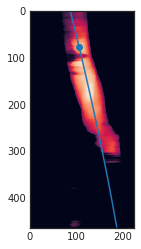

In [647]:
summedx = pred[..., 0].sum(1)
plt.imshow(summedx)

x, y = np.asarray(np.where(pred[..., 0] > .5))[[0, 2]]
z = np.polyfit(x, y, 2)
p = np.poly1d(z)

point = np.random.choice(np.unique(x))
a = p(point + 1) - p(point)
a = np.tan(np.arctan(a) + np.pi / 2)
w = np.poly1d([a, p(point) - a * point])

xp = np.linspace(x.min(), x.max(), 100)
# xw = np.linspace(point - 50, point + 50, 100)
plt.plot(p(xp), xp, '-');
# plt.plot(w(xw), xw, '-');
plt.scatter(p(point), point)
# plt.axis('off');

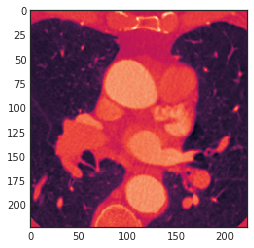

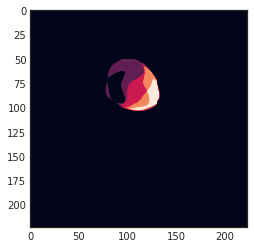

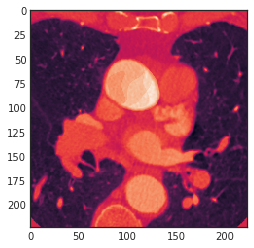

In [650]:
i = 100
plt.imshow(arr[i, ..., 0])
plt.show();
plt.imshow(pred[i, ..., 0]);
plt.show();
plt.imshow(arr[i, ..., 0] + pred[i, ..., 0]);

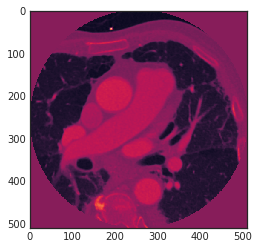

In [611]:
plt.imshow(patient[55])

In [429]:
a = next(test_gen)

p = model.predict(a[0])
p1 = model.predict(np.flip(a[0], 1))
p2 = model.predict(np.flip(a[0], 2))
p3 = model.predict(np.flip(np.flip(a[0], 2), 1))

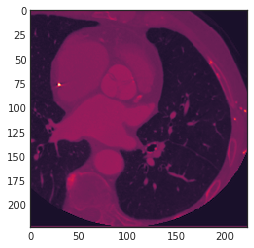

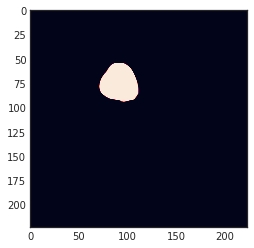

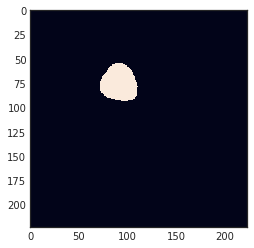

In [436]:
i = 3
plt.imshow(a[0][i, ..., 0])
plt.show()
plt.imshow(
    np.dstack([
        p[i, ..., 0], 
        np.flip(p1[i, ..., 0], 0), 
        np.flip(p2[i, ..., 0], 1), 
        np.flip(np.flip(p3[i, ..., 0], 1), 0),
    ]).mean(-1)
)
plt.show()
plt.imshow(a[1][i, ..., 0])
plt.show()

In [311]:
cval = -0.7
NUM = 100
for i in range(NUM):
    train_gen = generator(train, train_mode=True)

    model.fit_generator(
        train_gen,
        steps_per_epoch= 10 * len(train) // BATCH_SIZE + 1, 
        verbose=1, 
    )

    test_gen = generator(test, train_mode=False)
    valeval = model.evaluate_generator(test_gen, 3)

    print('Iteration %s/%s \n val dice: %s'%(i, NUM, valeval[0]))
    if valeval[0] < cval:
        cval = valeval[0]
        model.save(os.path.join(PATHS['DATA'], 'unet_model'))
        print('-' * 50)

Epoch 1/1
132/132 [==============================] - 169s 1s/step - loss: -0.6586 - dice_coef: 0.6586
Iteration 0/100 
 val dice: -0.655583860101
Epoch 1/1
132/132 [==============================] - 171s 1s/step - loss: -0.6622 - dice_coef: 0.6622
Iteration 1/100 
 val dice: -0.68024896931
Epoch 1/1
132/132 [==============================] - 171s 1s/step - loss: -0.6687 - dice_coef: 0.6687
Iteration 2/100 
 val dice: -0.707992120369
--------------------------------------------------
Epoch 1/1
132/132 [==============================] - 171s 1s/step - loss: -0.6725 - dice_coef: 0.6725
Iteration 3/100 
 val dice: -0.694832925861
Epoch 1/1
132/132 [==============================] - 171s 1s/step - loss: -0.6915 - dice_coef: 0.6915
Iteration 4/100 
 val dice: -0.716815722955
--------------------------------------------------
Epoch 1/1
132/132 [==============================] - 172s 1s/step - loss: -0.6889 - dice_coef: 0.6889
Iteration 5/100 
 val dice: -0.731835215478
-----------------------

132/132 [==============================] - 168s 1s/step - loss: -0.8567 - dice_coef: 0.8567
Iteration 50/100 
 val dice: -0.885753282019
Epoch 1/1
132/132 [==============================] - 167s 1s/step - loss: -0.8507 - dice_coef: 0.8507
Iteration 51/100 
 val dice: -0.890287755309
Epoch 1/1
132/132 [==============================] - 169s 1s/step - loss: -0.8430 - dice_coef: 0.8430
Iteration 52/100 
 val dice: -0.879257587162
Epoch 1/1
132/132 [==============================] - 167s 1s/step - loss: -0.8557 - dice_coef: 0.8557
Iteration 53/100 
 val dice: -0.878268797655
Epoch 1/1
Epoch 1/1
132/132 [==============================] - 168s 1s/step - loss: -0.8654 - dice_coef: 0.8654
Iteration 54/100 
 val dice: -0.882403492928
Epoch 1/1
132/132 [==============================] - 167s 1s/step - loss: -0.8652 - dice_coef: 0.8652
Iteration 55/100 
 val dice: -0.885561106978
Epoch 1/1
132/132 [==============================] - 167s 1s/step - loss: -0.8640 - dice_coef: 0.8640
Iteration 56/100

In [424]:
model.load_weights(os.path.join(PATHS['DATA'], 'unet_model'))

In [423]:
model.save(os.path.join(PATHS['DATA'], 'unet_model__'))

In [321]:
cval = -0.914
NUM = 100
for i in range(NUM):
    train_gen = generator(train, train_mode=True, batch_size=int(2 * BATCH_SIZE))

    model.fit_generator(
        train_gen,
        steps_per_epoch= 10 * len(train) // int(2 * BATCH_SIZE) + 1, 
        verbose=1, 
    )

    test_gen = generator(test, train_mode=False)
    valeval = model.evaluate_generator(test_gen, 3)

    print('Iteration %s/%s \n val dice: %s'%(i, NUM, valeval[0]))
    if valeval[0] < cval:
        cval = valeval[0]
        model.save(os.path.join(PATHS['DATA'], 'unet_model'))
        print('-' * 50)

Epoch 1/1
66/66 [==============================] - 179s 3s/step - loss: -0.8924 - dice_coef: 0.8924
Iteration 0/100 
 val dice: -0.887414555292
Epoch 1/1
66/66 [==============================] - 164s 2s/step - loss: -0.8906 - dice_coef: 0.8906
Iteration 1/100 
 val dice: -0.89599953471
Epoch 1/1
66/66 [==============================] - 164s 2s/step - loss: -0.8914 - dice_coef: 0.8914
Iteration 2/100 
 val dice: -0.885314422685
Epoch 1/1
66/66 [==============================] - 164s 2s/step - loss: -0.8957 - dice_coef: 0.8957
Iteration 3/100 
 val dice: -0.881032044823
Epoch 1/1
66/66 [==============================] - 164s 2s/step - loss: -0.8969 - dice_coef: 0.8969
Iteration 4/100 
 val dice: -0.897783566166
Epoch 1/1
66/66 [==============================] - 165s 2s/step - loss: -0.8932 - dice_coef: 0.8932
Iteration 5/100 
 val dice: -0.893910225984
Epoch 1/1
66/66 [==============================] - 165s 2s/step - loss: -0.8950 - dice_coef: 0.8950
Iteration 6/100 
 val dice: -0.894827

66/66 [==============================] - 164s 2s/step - loss: -0.9021 - dice_coef: 0.9021
Iteration 55/100 
 val dice: -0.913986889092
Epoch 1/1
66/66 [==============================] - 163s 2s/step - loss: -0.9021 - dice_coef: 0.9021
Iteration 56/100 
 val dice: -0.916543171212
Epoch 1/1
66/66 [==============================] - 165s 2s/step - loss: -0.9046 - dice_coef: 0.9046
Iteration 57/100 
 val dice: -0.91625430294
Epoch 1/1
66/66 [==============================] - 164s 2s/step - loss: -0.8960 - dice_coef: 0.8960
Iteration 58/100 
 val dice: -0.921112018663
--------------------------------------------------
Epoch 1/1
66/66 [==============================] - 163s 2s/step - loss: -0.8992 - dice_coef: 0.8992
Iteration 59/100 
 val dice: -0.896807127708
Epoch 1/1
66/66 [==============================] - 164s 2s/step - loss: -0.9036 - dice_coef: 0.9036
Iteration 60/100 
 val dice: -0.913467122091
Epoch 1/1
66/66 [==============================] - 166s 3s/step - loss: -0.9017 - dice_coe

In [293]:
test_gen = generator(test, train_mode=False)
model.evaluate_generator(test_gen, 3)

[-0.69859261448318899, 0.69859261448318899]

In [298]:
test_gen = generator(test, train_mode=False)
model.evaluate_generator(test_gen, 3)

[-0.68482592460271474, 0.68482592460271474]